In [50]:
import numpy as np
import sympy as sp
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt
import time

# Tarea 3:Interpolación Bicúbica

## Instrucciones

* La tarea es individual.
* Las consultas sobre las tareas se deben realizar por medio de la plataforma Aula.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`).
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, entre otras, así como la correcta implementación de algoritmos de forma vectorizada.
*  **El archivo de entrega debe denominarse ROL-tarea-numero.ipynb**. _De no respetarse este formato existirá un descuento de **50 puntos**_
* La fecha de entrega es el viernes 24 de Julio a las **18:00 hrs**.  Se aceptarán entregas hasta las 19:00 hrs sin descuento en caso de existir algun problema, posteriormente existirá un descuento lineal hasta las 20:00 hrs del mismo día.
* Las tareas que sean entregadas antes del jueves a mediodía recibirán una bonificación de 10 puntos
* Debe citar cualquier código ajeno utilizado (incluso si proviene de los Jupyter Notebooks del curso).


## Introducción

En la siguiente tarea estudiaremos un método de interpolación denominado **Interpolación Bicúbica**, utilizada frecuentemente sobre imágenes. Aplicaremos el método para aumentar la resolución de una imagen intentando preservar las propiedades de la versión original.

## Contexto

Supongamos que usted conoce $f$ y las derivadas $f_x$, $f_y$ y $f_{xy}$ dentro de las coordenadas $(0,0),(0,1),(1,0)$ y $(1,1)$ de un cuadrado unitario. La superficie que interpola estos 4 puntos es:

$$
p(x,y) = \sum\limits_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j.
$$

Como se puede observar el problema de interpolación se resume en determinar los 16 coeficientes $a_{ij}$ y para esto se genera un total de $16$ ecuaciones utilizando los valores conocidos de $f$,$f_x$,$f_y$ y $f_{xy}$. Por ejemplo, las primeras $4$ ecuaciones son:

$$
\begin{aligned}
f(0,0)&=p(0,0)=a_{00},\\
f(1,0)&=p(1,0)=a_{00}+a_{10}+a_{20}+a_{30},\\
f(0,1)&=p(0,1)=a_{00}+a_{01}+a_{02}+a_{03},\\
f(1,1)&=p(1,1)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=0}^{3}a_{ij}.
\end{aligned}
$$

Para las $12$ ecuaciones restantes se debe utilizar:

$$
\begin{aligned}
f_{x}(x,y)&=p_{x}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=0}^{3}a_{ij}ix^{i-1}y^{j},\\
f_{y}(x,y)&=p_{y}(x,y)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=1}^{3}a_{ij}x^{i}jy^{j-1},\\
f_{xy}(x,y)&=p_{xy}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=1}^{3}a_{ij}ix^{i-1}jy^{j-1}.
\end{aligned}
$$


Una vez planteadas las ecuaciones, los coeficientes se pueden obtener al resolver el problema $A\alpha=x$, donde $\alpha=\left[\begin{smallmatrix}a_{00}&a_{10}&a_{20}&a_{30}&a_{01}&a_{11}&a_{21}&a_{31}&a_{02}&a_{12}&a_{22}&a_{32}&a_{03}&a_{13}&a_{23}&a_{33}\end{smallmatrix}\right]^T$ y ${\displaystyle x=\left[{\begin{smallmatrix}f(0,0)&f(1,0)&f(0,1)&f(1,1)&f_{x}(0,0)&f_{x}(1,0)&f_{x}(0,1)&f_{x}(1,1)&f_{y}(0,0)&f_{y}(1,0)&f_{y}(0,1)&f_{y}(1,1)&f_{xy}(0,0)&f_{xy}(1,0)&f_{xy}(0,1)&f_{xy}(1,1)\end{smallmatrix}}\right]^{T}}$.


In [ ]:
A_f(0,0) = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
A_f(1,0) = [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
A_f(0,1) = [1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
A_f(1,1) = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

#00 10 01 11
A_{f_x}(x,y) = [0 1 2*x 3*x**2 0 y 2*x*y 3*x**2*y**3 0 y**2 2*x*y**2 3*x**2*y**2 0 y**3 2*x*y**3 3*x**2*y**3]

A_{f_y}(x,y) = [0 0 0 0 1 x x**2 x**3 2*y 2*x*y 2*x**2*y 2*x**3*y 3*y**2 3*x*y**2 3*x**2*y**2 3*x**3*y**2]

A_{f_xy}(x,y) = [0 0 0 0 0 1 2*x 3*x**2 0 2*y 4*x*y 6*x**2*y 0 3*y**2 6*x*y**2 9*x**2*y**2]

En un contexto más aplicado, podemos hacer uso de la interpolación bicúbica para aumentar la resolución de una imagen. Supongamos que tenemos la siguiente imagen de tamaño $5 \times 5$:

<img src="img1.png" width="20%"/>

Podemos ir tomando segmentos de la imagen de tamaño $2 \times 2$ de la siguiente forma:

<img src="img2.png" width="50%"/>

Por cada segmento podemos generar una superficie interpoladora mediante el algoritmo de interpolación cubica. Para el ejemplo anterior estariamos generando $16$ superficies interpoladoras distintas. La idea es hacer uso de estas superficies para estimar los valores de los pixeles correspondientes a una imagen más grande. Por ejemplo, la imagen $5 \times 5$ la podemos convertir a una imagen de $9 \times 9$ agregando un pixel entre cada par de pixeles originales además de uno en el centro para que no quede un hueco.

<img src="img3.png" width="50%"/>

Acá los pixeles verdes son los mismos que la imagen original y los azules son obtenidos de evaluar cada superficie interpoladora. Notar que existen pixeles azules que se pueden obtener a partir de dos superficies interpoladoras distintas, en esos casos se puede promediar el valor de los pixeles o simplemente dejar uno de los dos. 

Para trabajar con la interpolación bicubica necesitamos conocer los valores de $f_x$, $f_y$ y $f_{xy}$. En el caso de las imágenes solo tenemos acceso al valor de cada pixel por lo que deberemos estimar cual es el valor de estos. Para estimar $f_x$ haremos lo siguiente:

## Para estimar el valor de $f_x$ en cada pixel haremos una interpolación con los algoritmos conocidos, usando tres pixeles en dirección de las filas, luego derivaremos el polinomio obtenido y finalmente evaluaremos en la posición de interés. La misma idea aplica para $f_y$ solo que ahora interpolaremos en dirección de las columnas.

<img src="img5.png" width="60%"/>

Por ejemplo si queremos obtener el valor de $f_x$ en la posición $(0,0)$ (imagen de la izquierda) entonces haremos una interpolación de Lagrange utilizando los pixeles $(0,-1),(0,0)$ y $(0,1)$. Derivaremos el polinomio interpolador y evaluaremos en $(0,0)$. Por otro lado si queremos obtener el valor de $f_y$ en la posición $(0,0)$ (imagen de la derecha) entonces interpolaremos los pixeles $(-1,0),(0,0)$ y $(1,0)$. Luego derivaremos el polinomio interpolador y evaluaremos en $(0,0)$.

Para obtener $f_{xy}$ seguiremos la idea anterior. Solo que esta vez se utilizaran los valores de $f_y$ y se interpolaran estos en dirección de las filas.

# Preguntas

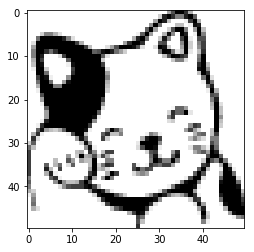

In [56]:
#Codigo para abrir y visualizar imágenes
img = Image.open('./imagenes_prueba/cat.png')
array = np.array(img.convert('RGB'))
#array = np.array(img)
imgplot = plt.imshow(array)
plt.show()

## 1. Interpolación bicubica

### 1.1  Obtener derivadas (30 puntos)

Implemente la función `derivativeValues` que reciba como input un arreglo con valores, el método de interpolación y si es que se considera el uso de  los puntos de chebyshev . La función debe retornar un arreglo de igual dimensión con los valores de las derivadas obtenidas de los puntos.

Los métodos de interpolación serán representados por los siguientes valores

* Interpolación de lagrange: `'lagrange'`
* Diferencias divididas de Newton: `'newton'`
* Spline cubica: `'spline3'`


In [51]:
 def derivativeValues(values, method, cheb):
    """
    Parameters
    ----------
    values:	(int array) points values
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used

    Returns
    -------
    d:	(float array) derivative value of interpolated points

    """
    
    n = values.shape[0]    
    
    #Puntos x
    if cheb:
        x_arr = [0.5 + 0.5*np.cos((2*i - 1)*np.pi / (2*n)) for i in range(1, n + 1)]
        x_arr.reverse()
        x_arr = np.array(x_arr)
    
    else:
         x_arr = np.linspace(0, 1, n)
    
    #Interpolar
    if method == 'lagrange' or method == 'Lagrange':
        interFunc = interpolate.lagrange(x_arr, values)
        d = interFunc.deriv()(x_arr)
        
    elif method == 'newton' or method == 'Newton':
        
        dd = np.array([values])
        for i in range(n - 1):

            ddi = []
            for a in range(n - i - 1):
                
                ddi.append( (dd[i][a + 1] - dd[i][a]) / (x_arr[a + i + 1] - x_arr[a]) )
            
            ddi = np.append(ddi, np.full((n - len(ddi),),0.0))
            
            dd = np.append(dd, [ddi], axis=0)
        
        dd = np.array(dd)
        factores = [i for i in [j[0] for j in dd]]
        
        #función interpoladora
        x = sp.Symbol('x')
        interFunc = np.dot(factores, np.append([1],[np.prod(x - x_arr[:i]) for i in range(1, len(dd))]))
        d = [sp.lambdify(x,sp.diff(interFunc))(i) for i in x_arr]
        
    elif method == 'spline3':
        
        interFunc = interpolate.CubicSpline(x_arr,values)
        d = interFunc(x_arr,1)
    
    return d


### 1.2 Interpolación de imagen (50 puntos)
Implemente la función `bicubicInterpolation` que reciba como input la matriz de la imagen y cuantos píxeles extra se quiere agregar entre los píxeles originales y el algoritmo de interpolación a utilizar. La función debe retornar la matriz con la imagen de dimensión nueva. Considere que se debe aplicar el método de interpolación en cada canal RGB por separado.

In [52]:
def constr_A ():
    
    X = np.array([0,1,0,1])
    Y = np.array([0,0,1,1])
    A = np.zeros([16,16],np.int32)
    
    #condiciones
    A[0] = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    A[1] = [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]
    A[2] = [1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0]
    A[3] = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

    
    #00,10,01,11
    #derivadas X[i]
    for i in range(4):
        #A[4:8]
        A[4 + i] = [0,1,2*X[i],3*X[i]**2,0,Y[i],2*X[i]*Y[i],3*X[i]**2*Y[i]**3,0,Y[i]**2,2*X[i]*Y[i]**2,3*X[i]**2*Y[i]**2,0,Y[i]**3,2*X[i]*Y[i]**3,3*X[i]**2*Y[i]**3]
        
        #A[8:12]
        A[8 + i] = [0,0,0,0,1,X[i],X[i]**2,X[i]**3,2*Y[i],2*X[i]*Y[i],2*X[i]**2*Y[i],2*X[i]**3*Y[i],3*Y[i]**2,3*X[i]*Y[i]**2,3*X[i]**2*Y[i]**2,3*X[i]**3*Y[i]**2]
        
        #A[12:16]
        A[12 + i] = [0,0,0,0,0,1,2*X[i],3*X[i]**2,0,2*Y[i],4*X[i]*Y[i],6*X[i]**2*Y[i],0,3*Y[i]**2,6*X[i]*Y[i]**2,9*X[i]**2*Y[i]**2]
        
    return A

In [53]:
#Resultado según función interpoladora
#x,y: int
#a: arreglo con constantes de polinomio (00 10 20 30 10 11 21 31 ...)
def InterP(x, y, a):
    
    res = 0
    k = 0
    
    for j in range(4):
        for i in range(4):
        
            res += a[k] * x**i * y**j
            k += 1
            
    return res

In [73]:
def bicubicInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	number of extra pixels between the original ones
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    newImage:	(nxnx3 array) image array in RGB format

    """
    
    Img = np.array(image.convert('RGB'))
    n = Img.shape[0]
    
    #nuevo arreglo
    newShp = n + interiorPixels*(n - 1)
    newImg = np.zeros([newShp,newShp,3],np.int32)
    
    
    #puntos x
    if cheb:
        x_arr = [0.5 + 0.5*np.cos((2*i - 1)*np.pi / (2*(interiorPixels + 2))) for i in range(1, (interiorPixels + 2) + 1)]
        x_arr.reverse()
        x_arr = np.array(x_arr)
    
    else:
         x_arr = np.linspace(0, 1, interiorPixels + 2)
    
    
    #arreglo 3xnxn
    arrImg = np.zeros([3,n,n],np.int32)
    f = 0
    for fila in Img:
        c = 0
        for col in fila:
            l = 0
            for capa in col:

                arrImg[l][f][c] = Img[f][c][l]

                l += 1
            c += 1
        f += 1
    
    
    #matrices con derivadas de x e y
    Mx = np.zeros([3,n,n])
    My = np.zeros([3,n,n])
    
    #submatrices
    sm = np.zeros(4, dict)
    
    A = constr_A()
    X = np.zeros(16)
    
    l = 0
    for capa in arrImg:
        
        #obtener submatrices como parámetros
        for i in range(n - 1): #mover submatriz en y
            for j in range(n - 1): #mover submatriz en x
                
                
                #sm: 00 10 01 11
            
                sm[0] = {"i":i, "j": j}
                sm[1] = {"i":i+1, "j": j}
                sm[2] = {"i":i, "j": j+1}
                sm[3] = {"i":i+1, "j": j+1}
                
                
                #Derivaciones
                for k in range(4):
                    
                    #cada variable es el arreglo derivado
                    #se ocupa un 0 en los casos de borde
                    #capa[sm[k]["i"]][sm[k]["j"]] corresponde a capa[i][j]
                    
                    if i == 0:
                        diffArr_y = np.array([0, capa[sm[k]["i"]][sm[k]["j"]], capa[sm[k]["i"] + 1][sm[k]["j"]] ])
                    elif i == n - 1:
                        diffArr_y = np.array([capa[sm[k]["i"] - 1][sm[k]["j"]], capa[sm[k]["i"]][sm[k]["j"]], 0])
                    else:
                        diffArr_y = np.array([capa[sm[k]["i"] - 1][sm[k]["j"]], capa[sm[k]["i"]][sm[k]["j"]], capa[sm[k]["i"] + 1][sm[k]["j"]] ])
                    
                    if j == 0:
                        diffArr_x = np.array([0, capa[sm[k]["i"]][sm[k]["j"]], capa[sm[k]["i"]][sm[k]["j"] + 1]])
                    elif j >= n - 2:
                        diffArr_x = np.array([capa[sm[k]["i"]][sm[k]["j"] - 1], capa[sm[k]["i"]][sm[k]["j"]], 0])
                    else:
                        diffArr_x = np.array([capa[sm[k]["i"]][sm[k]["j"] - 1], capa[sm[k]["i"]][sm[k]["j"]], capa[sm[k]["i"]][sm[k]["j"] + 1] ])
                    
                    
                    Mx[l][i][j] = derivativeValues(diffArr_x, method, cheb)[1]
                    My[l][i][j] = derivativeValues(diffArr_y, method, cheb)[1]      
                    
        
        #aumenta capa
        l+= 1     
                
    #tengo matrices con derivadas x.x
    
    
    #Nuevamente, para obtener f_xy en una nueva matriz
    Mxy = np.zeros([n,n,3])
    
    l = 0
    for capa in My:
        for i in range(n - 1):
            for j in range(n - 1):
                
                sm[0] = {"i":i, "j": j}
                sm[1] = {"i":i+1, "j": j}
                sm[2] = {"i":i, "j": j+1}
                sm[3] = {"i":i+1, "j": j+1}
                

                if j == 0:
                    diffArr_xy = np.array([0, capa[sm[k]["i"]][sm[k]["j"]], capa[sm[k]["i"]][sm[k]["j"] + 1]])
                elif j >= n - 2:
                    diffArr_xy = np.array([capa[sm[k]["i"]][sm[k]["j"] - 1], capa[sm[k]["i"]][sm[k]["j"]], 0])
                else:
                    diffArr_xy = np.array([capa[sm[k]["i"]][sm[k]["j"] - 1], capa[sm[k]["i"]][sm[k]["j"]], capa[sm[k]["i"]][sm[k]["j"] + 1] ])
                
                Mxy[l][i][j] = derivativeValues(diffArr_xy, method, cheb)[1]                                                                                     
                    
        l += 1
    
    #una más > <
    l = 0           
    for capa in arrImg:
        for i in range(n - 1):
            for j in range(n - 1):
                
                X[0] = capa[i][j]
                X[1] = capa[i + 1][j]
                X[2] = capa[i][j + 1]
                X[3] = capa[i + 1][j + 1]
                
                X[4] = Mx[i][j][l]
                X[5] = Mx[i + 1][j][l]
                X[6] = Mx[i][j + 1][l]
                X[7] = Mx[i + 1][j + 1][l]
                
                X[8] = My[i][j][l]
                X[9] = My[i + 1][j][l]
                X[10] = My[i][j + 1][l]
                X[11] = My[i + 1][j + 1][l]
                
                X[12] = Mxy[i][j][l]
                X[13] = Mxy[i + 1][j][l]
                X[14] = Mxy[i][j + 1][l]
                X[15] = Mxy[i + 1][j + 1][l]
                    
                
                a = np.solve(A,X)
                
                
                #llenar nueva matriz con valores evaluados en funcion interpoladora
                
                index_aux1 = 0
                for ip1 in range(interiorPixels):
                    index_aux2 = 0
                    for ip2 in range(interiorPixels):
                    
                        newImage[i + ip1][j + ip2][l] = InterP(i+x_arr[index_aux1], j+x_arr[index_aux2], a) #<<<<<<
                        index_aux2 += 1
                    
                    index_aux1 += 1
                    
        l += 1
        
        
    l = 0
    for capa in arrImg:
        f = 0
        for i in range(n):
            c = 0
            for j in range(n):
                newImage[f][c][l] = arrImg[l][f][c] 
                c += 1
            f += 1
        l += 1
                
        
    return newImage

In [74]:
#array = np.array(img.convert('RGB'))
nI = bicubicInterpolation(img, 5, "lagrange",True)

imgplot = plt.imshow(nI)
plt.show()

IndexError: index 50 is out of bounds for axis 0 with size 50

## 2. Evaluacion de algoritmos



### 2.1 Tiempo de ejecucion 
Implemente la funcion `timeInterpolation` que mida el tiempo de interpolacion de una imagen dado el algoritmo de interpolacion , en segundos.(5 puntos)

In [ ]:
def timeInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    time:	(float) time in seconds

    """
    t1 = time.time()
    bicubicInterpolation(image, interiorPixels, method,cheb)
    t2 = time.time()
    time = t2-t1
    
    return time

***Pregunta: ¿Cual es el metodo que presenta mayor velocidad en general? (5 puntos)***

Lagrange.

### 2.2 Calculo de error
Implemente la funcion `errorInterpolation` la cual debe obtener el error de la imagen obtenida comparandola con una de referencia. El error debe ser calculado utilizando el indice SSIM (Structural similarity) (5 puntos)

In [ ]:
def errorInterpolation(original,new):
    """
    Parameters
    ----------
    image:	(nxn array) original image array in RGB format
    new:	(nxn array) new image array in RGB format obtained from interpolation


    Returns
    -------
    error:	(float) difference between images 

    """
    
    return error

***Pregunta: ¿Cual metodo presenta menor error? (5 puntos)***

# Consideraciones

* Solo trabajaremos con imagenes cuadradas
* En el caso que el valor interpolado de un punto sea mayor a 255 o menor a 0, este se trunca a 255 o 0 respectivamente
* Esta permitido el uso de sympy para calcular derivadas y para construir el polinomio interpolador 
* El calculo de error puede ser calculado utilizando la imagen en escala de grises [(ejemplo)](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html)

Referencias

(1) Github - SC1 - 07_Polynomial_Interpolation_1D.ipynb